<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

## Data Preprocessing

In [ ]:
from torchinfo import summary

In [ ]:
# Load the TensorBoard notebook extension

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader, Dataset, random_split

import torch
import os
from PIL import Image

from tqdm import tqdm 
import matplotlib.pyplot as plt
import timm
import numpy as np
from datetime import datetime

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class CountryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGBA")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
from torchvision import transforms

# Define transforms to apply to the images
transform_default = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.406],
                         std=[0.229, 0.224, 0.225, 0.225]),  
    # Normalize with ImageNet mean and std

])

# Path to the root directory of the dataset
root_dir = 'Data/country211_depth/country211/train'

# Create datasets
train_dataset = CountryDataset(root_dir,
                               transform=transform_default,)
# val_dataset = datasets.Country211(root_dir,
#                                    split = 'valid',
#                                     transform=transform_default,
#                                     download = False)
# test_dataset = datasets.Country211(root_dir,
#                                    split = 'test',
#                                     transform=transform_default,
#                                     download = False)

In [ ]:
len(train_dataset)

31650

In [ ]:
images, label = train_dataset[1000]

In [ ]:
images.shape

torch.Size([4, 150, 150])

In [ ]:
len(train_dataset.classes)

211

In [ ]:
train_dataset

<__main__.CountryDataset>

In [ ]:
train_dataset.__dict__.keys()

dict_keys(['root_dir', 'transform', 'image_paths', 'labels', 'classes', 'class_to_idx'])

In [ ]:
# Define a function to display images
def show_image(dataset):
    # Access an image and its label from the dataset
    image, label = dataset
    # Convert the image tensor to a NumPy array
    image_np = image.numpy().transpose((1, 2, 0))

    # Display the image using Matplotlib
    plt.imshow(image_np.clip(0,1))
    plt.axis('off')
    plt.title(f' {train_dataset.classes[label]}')
    plt.show()
    
   
# Define a function to display images
def show_images(images, labels, **kwargs):
    nrows = int(np.ceil(np.sqrt(len(images))))
    ncols = int(np.ceil(len(images)/nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12),  **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for ax, image, label in zip(axes.flat, images, labels):
        # Convert image to numpy array and adjust pixel values
        img_np = image.numpy().transpose((1, 2, 0))
        
        # Display image
        ax.imshow(img_np.clip(0,1))
        ax.axis('off')
        ax.set_title(f' {train_dataset.classes[label]}')
    for ax in axes.flat[len(images):]:
        ax.axis('off')
        
    plt.show()

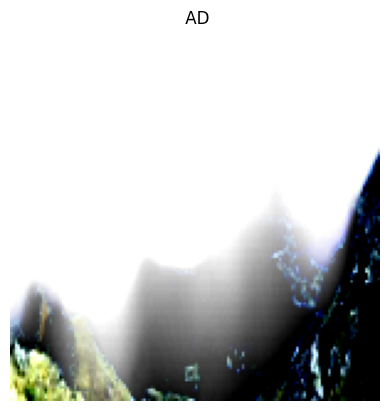

In [ ]:
show_image(train_dataset[6])

In [ ]:
def loaders(batch_size):

    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=8)

    # dataloaders = {'train': train_loader, 'val': test_loader}
    # dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset) }
    return train_loader

In [ ]:
batch_size = 32
train_loader = loaders(batch_size)

In [ ]:
# Get a batch of images and labels from the data loader
examples = iter(train_loader)
images, labels = next(examples)
# ############## TENSORBOARD ########################
# img_grid = utils.make_grid(images)

# writer.add_image('Imagenette', img_grid)
# writer.flush()
# #sys.exit()
# ###################################################

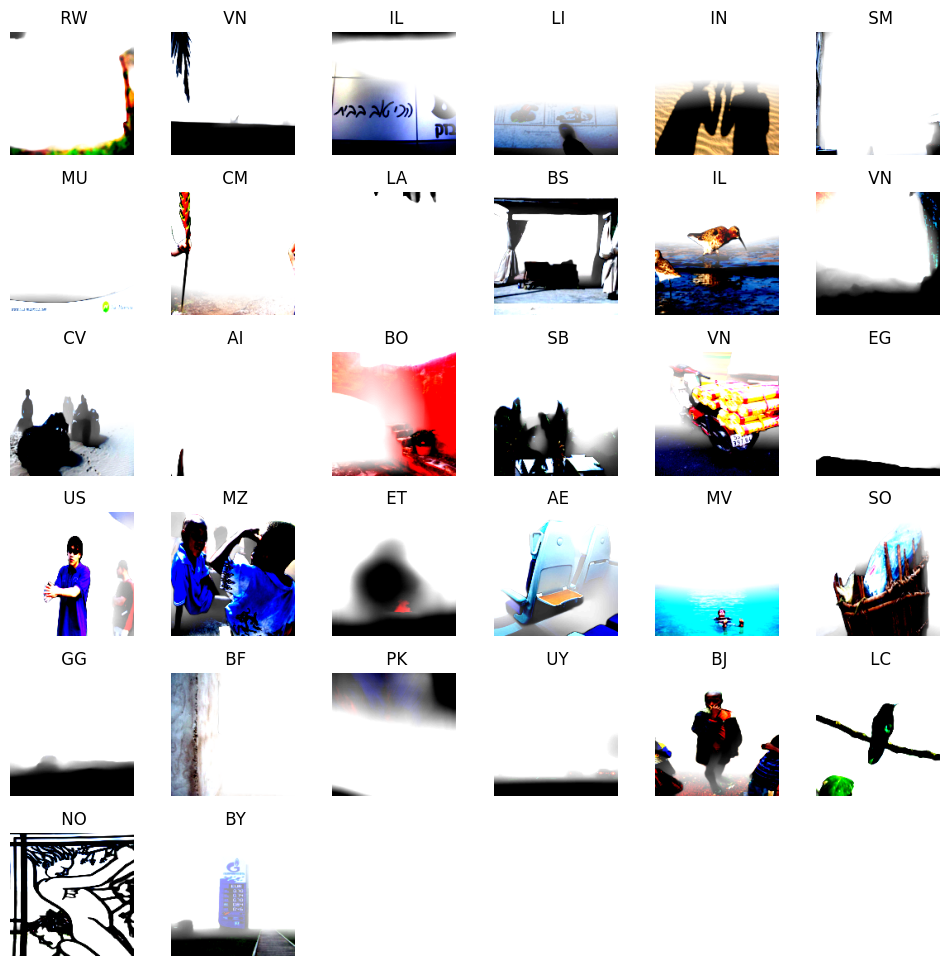

In [ ]:
show_images(images, labels)

## Model

In [ ]:
def train_model(model, criterion, 
                optimizer, scheduler, 
                train_loader, epoch,
                n_total_steps, record = 10):
    running_loss = 0.0
    running_correct = 0
    model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):  
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % record == 0:
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / record, epoch * n_total_steps + i)
            running_accuracy = running_correct / record / len(images)
            writer.add_scalar('training accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0.0
            writer.flush()
            ###################################################
    scheduler.step()
    

def eval_model(model, criterion, 
               optimizer, scheduler, 
               test_loader, epoch,
               n_total_steps, batch_size):
    running_loss = 0.0
    running_correct = 0
    running_accuracy = 0
    
    model.eval()
    len_batch = 0
    for i, (images, labels) in enumerate(tqdm(test_loader)):  
        images = images.to(device)
        labels = labels.to(device)
        len_batch = len(images)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        
    ############## TENSORBOARD ########################
    writer.add_scalar('val loss',
                      running_loss / len(test_loader),
                      (epoch+1) * n_total_steps)
    running_accuracy = running_correct / len(test_loader) / batch_size
    writer.add_scalar('val accuracy',
                      running_accuracy,
                      (epoch+1) * n_total_steps)

    writer.flush()
    ###################################################

In [ ]:
def build_model(model, criterion, optimizer,
                scheduler, num_epochs=5, batch_size = 32, record = 10):
    
    train_loader = loaders(batch_size)

    model = model.to(device)

    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        train_model(model, criterion,
                    optimizer, scheduler,
                    train_loader, epoch,
                    n_total_steps, record = record)

        # eval_model(model, criterion, 
        #            optimizer, scheduler, 
        #            val_loader, epoch, 
        #            n_total_steps, batch_size)

    return model

In [ ]:
def start_tensorboard(file_name):
    ######################## TENSORBOARD ########################
    import sys
    from torch.utils.tensorboard import SummaryWriter
    from datetime import datetime
    # default `log_dir` is "runs" - we'll be more specific here
    formatted_time =  datetime.now().strftime("%H:%M:%S")
    
    writer = SummaryWriter(log_dir = f'{file_name} {formatted_time}')
    print(f'{file_name} {formatted_time}')
    
    writer.add_text('learning_rate', f'{learning_rate}')
    writer.add_text('epochs', f'{num_epochs}')
    writer.add_text('batch_size', f'{batch_size}')
    writer.add_text('criterion', f'{str(criterion)}')
    writer.add_text('optimizer', f'{str(optimizer)}')
    
    writer.flush()
    ###################################################
    return writer

## default setup

In [ ]:
# model = timm.create_model('resnet18',
#                           pretrained=True,
#                           num_classes=10)

In [ ]:
# learning_rate = 0.1
# num_epochs = 5
# batch_size = 64
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# ############## TENSORBOARD ########################
# import sys
# from torch.utils.tensorboard import SummaryWriter
# # default `log_dir` is "runs" - we'll be more specific here
# formatted_time =  datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

# writer = SummaryWriter(log_dir = f'runs/transforms everything {formatted_time}')

# writer.add_text('learning_rate', f'{learning_rate}')
# writer.add_text('epochs', f'{num_epochs}')
# writer.add_text('batch_size', f'{batch_size}')
# writer.add_text('criterion', f'{str(criterion)}')
# writer.add_text('optimizer', f'{str(optimizer)}')

# writer.add_graph(model, images)
# writer.flush()
# ###################################################

In [ ]:
# model = build_model(model = model,
#                     criterion = criterion,
#                     optimizer = optimizer,
#                     scheduler = step_lr_scheduler,
#                     num_epochs = num_epochs,
#                     batch_size = batch_size,
#                     record = 20)

In [ ]:
# del model
# torch.cuda.empty_cache()

In [ ]:
# ############## TENSORBOARD ########################
# writer.close()
# ###################################################

## Test Loop

In [ ]:
learning_rate = 0.5
num_epochs = 10
batch_size = 64
criterion = nn.CrossEntropyLoss()

In [ ]:
def create_custom_model(model_name: str,
                        pretrained: bool = False,
                        input_channels:int = 3,
                        **kwargs):
    model = timm.create_model(model_name,
                              pretrained=pretrained,
                              **kwargs)


    model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False) 

    return model

In [ ]:
for i in range(1):
    model = create_custom_model('resnet34',
                                pretrained=True,
                                input_channels=4,
                                num_classes=211)
    # optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
    
    writer = start_tensorboard(f'country211/start {num_epochs} {batch_size} {learning_rate}')

    model = build_model(model = model,
                        criterion = criterion,
                        optimizer = optimizer,
                        scheduler = step_lr_scheduler,
                        num_epochs = num_epochs,
                        batch_size = batch_size,
                        record = 50)
    del model
    torch.cuda.empty_cache()
    
    ######################## TENSORBOARD ########################
    writer.close()
    ###################################################

country211/start 10 64 0.5 04:27:21


100%|█████████████████████████████████████████████████████████████████████████████████| 495/495 [01:33<00:00,  5.28it/s]


In [ ]:
from torchinfo import summary

In [ ]:
random_input = np.random.rand(1, 4, 150, 150)

In [ ]:
summary(model, input_size=random_input.shape, verbose = 0, depth  = 1, col_names = (
                "input_size",
                "output_size",
                "num_params",
                "params_percent",
                "kernel_size",
                "mult_adds",
                "trainable",
            ))

NameError: name 'model' is not defined